In [147]:
#!pip3 install gym

In [148]:
import gym
import time
import random
import numpy as np
import matplotlib.pyplot as plt

# Frozen Lake

In [149]:
holes = (13,14,16,22,23,25)
holesgain = (13,14,16,22,23,25,35) # position of the holes and the gain cell
holes_double = (4,8,13,17,20,24,26,28,35,44,52,54,56,72,73,74,75,82,84,86,92,94,98,104,106,108,115,118,115,118,120,125,128,130,135)
holesgain_double = (4,8,13,17,20,24,26,28,35,44,52,54,56,72,73,74,75,82,84,86,92,94,98,104,106,108,115,118,115,118,120,125,128,130,135,143)
FLsize = 36

In [150]:
class FL:
    '''Frozen Lake class'''
    def __init__(self, slippery=0, d_reward=-0.04, double_size=False):
        self.reward = 0
        self.position = 0
        self.done = False
        self.slippery = slippery
        self.d_reward = d_reward
        self.double_size= double_size
        
    def reset(self):
        self.reward = 0
        self.position = 0
        self.done = False
        
    def next_position(self, action):
        if self.double_size == False:
            if action == 0 and self.position % 6 != 5:
                return self.position+1
            if action == 1 and self.position < 30:
                return self.position+6
            if action == 2 and self.position % 6 != 0:
                return self.position-1
            if action == 3 and self.position > 5:
                return self.position-6
            return self.position
        else:
            if action == 0 and self.position % 12 != 11:
                return self.position+1
            if action == 1 and self.position < 132:
                return self.position+12
            if action == 2 and self.position % 12 != 0:
                return self.position-1
            if action == 3 and self.position > 11:
                return self.position-12
            return self.position
        
    def transitions(self, action):
        rep = [1-self.slippery,self.slippery/2,self.slippery/2]
        out = ((rep[0],self.next_position(action)),(rep[1],self.next_position((action+1)%4)),(rep[2],self.next_position((action+3)%4)))
        return out
    
    def rewards(self):
        if (self.double_size== False and self.position in holes) or (self.double_size==True and self.position in holes_double):
            self.reward = -1
            self.done = True
        elif (self.position == 35 and self.double_size == False) or (self.position == 143 and self.double_size == True):
            self.reward = 1
            self.done = True
        else:
            self.reward = self.d_reward
        
    def step(self, action):
        TR = self.transitions(action)
        r = random.random()
        counter = 0
        for tr in TR:
            counter += tr[0]
            if r <= counter:
                self.position = tr[1]
                break
        self.rewards()

In [151]:
fl = FL(0, -0.01, True)
fl.step(1)
print(fl.position)
fl.step(1)
print(fl.position)
fl.step(1)
fl.reward
print(fl.position)

12
24
36


## Value iteration

In [152]:
def value_iteration(s, d_reward, gamma=0.5, nb_iter=4, double_size=False):
    FLsize = 36
    U = np.zeros((FLsize,))
    U[[13,14,16,22,23,25]] = -1
    holesgain = (13,14,16,22,23,25,35)
    if double_size:
        FLsize=144
        U = np.zeros((FLsize,))
        U[[4,8,13,17,20,24,26,28,35,44,52,54,56,72,73,74,75,82,84,86,92,94,98,104,106,108,115,118,115,118,120,125,128,130,135]] = -1
        holesgain = holesgain_double
    U[FLsize-1] = 1
    actions = (0,1,2,3)
    fl = FL(s, d_reward, double_size)
    for _ in range(nb_iter):
        for p in range(FLsize):
            if p not in holesgain:
                maxi = np.zeros((4,))
                fl.position = p
                for i,action in enumerate(actions):
                    TRs = fl.transitions(action)
                    for tr in TRs:
                        maxi[i] += tr[0]*U[tr[1]]
                fl.rewards()
                U[p] = fl.reward + gamma * np.max(maxi)
    return U

def policy_from_value_iteration(s, d_reward, U, double_size=False):
    FLsize = 36
    PI = np.zeros((FLsize,)).astype(int).astype(str)
    PI[[13,14,16,22,23,25]] = '-10'
    holesgain = (13,14,16,22,23,25,35)
    if double_size:
        FLsize=144
        PI = np.zeros((FLsize,)).astype(int).astype(str)
        PI[[4,8,13,17,20,24,26,28,35,44,52,54,56,72,73,74,75,82,84,86,92,94,98,104,106,108,115,118,115,118,120,125,128,130,135]] = '-10'
        holesgain = holesgain_double
    PI[FLsize-1] = '10'
    actions = (0,1,2,3)
    fl = FL(s, d_reward, double_size)
    for p in range(FLsize):
        if p not in holesgain:
            maxi = np.zeros((4,))
            fl.position = p
            for i,action in enumerate(actions):
                TRs = fl.transitions(action)
                for tr in TRs:
                    maxi[i] += tr[0]*U[tr[1]]
            a = ','.join(map(str,np.argwhere(maxi==np.amax(maxi)).flatten().tolist()))
            PI[p] = str(np.argmax(maxi))
    return PI

In [153]:
U = value_iteration(s=0, d_reward=-0.04, gamma=0.5, nb_iter=30, double_size=True)
#print(U.reshape((8,8)))
PI = policy_from_value_iteration(s=0, d_reward=-0.04, U=U, double_size=True)
print(PI.reshape((12,12)))

[['0' '0' '0' '1' '-10' '0' '0' '1' '-10' '0' '1' '1']
 ['3' '-10' '0' '1' '2' '-10' '0' '1' '-10' '0' '1' '2']
 ['-10' '1' '-10' '1' '-10' '0' '0' '0' '0' '0' '1' '-10']
 ['0' '0' '0' '0' '0' '0' '0' '1' '-10' '0' '0' '1']
 ['0' '0' '0' '1' '-10' '1' '-10' '1' '-10' '0' '0' '1']
 ['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '1']
 ['-10' '-10' '-10' '-10' '0' '0' '0' '0' '0' '1' '-10' '1']
 ['-10' '1' '-10' '0' '0' '0' '1' '1' '-10' '1' '-10' '1']
 ['0' '1' '-10' '0' '0' '0' '1' '2' '-10' '1' '-10' '1']
 ['-10' '0' '0' '0' '0' '0' '1' '-10' '0' '1' '-10' '1']
 ['-10' '0' '0' '0' '1' '-10' '0' '1' '-10' '1' '-10' '1']
 ['0' '0' '3' '-10' '0' '0' '0' '0' '0' '0' '0' '10']]


# Evaluation

In [154]:
def f(x):
    if x == '0':
        return '>'
    if x == '1':
        return 'V'
    if x == '2':
        return '<'
    if x == '3':
        return '^'
    if x == '-10':
        return 'H'
    return 'G'

fr = np.vectorize(f)

def myround(x):
    return round(x,2)

vr = np.vectorize(myround)

In [155]:
def evaluate_policy(s, d_reward, PI, double_size=False):
    Rs = np.zeros((10,))
    for i in range(10):
        fl = FL(s, d_reward, double_size)
        R = 0
        while fl.done == False and R > -10 and R < 10:
            a = int(PI[fl.position])
            fl.step(a)
            R += fl.reward
        Rs[i] = R
    return np.mean(Rs), np.std(Rs)

In [156]:
def plot_score_vs_iteration(s, d_reward, nb_iter, gammas, alg, alpha=0.5, exploration='epsilon', double_size=False):
    size = 6
    if double_size:
        size=12
    if nb_iter >= 100:
        iters = range(0,nb_iter, int(0.1*nb_iter))
    else:
        iters = range(nb_iter)
    means = np.zeros((len(iters),))
    stds= np.zeros((len(iters),))
    ts = np.zeros((len(iters),))
    store_U = []
    store_PI = []
    plt.figure()
    if alg == 'vi' or alg == 'pi':
        plt.title('Score vs Nb of iterations - ' + str(alg) + ' (s=' + str(s) + '; d_reward=' + str(d_reward) + ')')
    else:
        plt.title('Score vs Nb of iterations - ' + str(alg) + ' ex_stra:' + exploration + ' (s=' + str(s) + '; d_reward=' + str(d_reward) + ')')
    plt.grid()
    plt.ylabel('Score')
    plt.xlabel('Nb iterations')
    for c,gamma in enumerate(gammas):
        for index,i in enumerate(iters):
            print(i, end=' ')
            if alg == 'vi':
                t1 = time.time()
                u = True
                U = value_iteration(s, d_reward, gamma, i, double_size=double_size)
                PI = policy_from_value_iteration(s, d_reward, U, double_size=double_size)
                ts[index] = time.time()-t1
            if alg == 'pi':
                t1 = time.time()
                u = True
                U, PI = policy_iteration(s, d_reward, gamma, i, double_size=double_size)
                ts[index] = time.time()-t1
            if alg == 'ql':
                t1 = time.time()
                u = None
                Q = Qlearning(s, d_reward, gamma, i, alpha=alpha, exploration=exploration, double_size=double_size)
                PI = policy_from_Q(Q)
                ts[index] = time.time()-t1
            means[index], stds[index] = evaluate_policy(s, d_reward, PI, double_size=double_size)
        plt.plot(iters, means, label='gamma='+str(gamma))
        plt.fill_between(iters, means-stds/2,means+stds/2)
        print('\nLast Utility, gamma=' + str(gamma)+ ' :')
        if u:
            store_U.append(vr(U).reshape((size,size)))
        store_PI.append(PI.reshape((size,size)).astype(np.float))
    plt.legend()
    if u:
        fig = plt.figure(figsize=(6,7))
        for c,gamma in enumerate(gammas):
            ax = fig.add_subplot(2,2,c+1)
            U = store_U[c]
            ax.set_title('Gamma='+str(gamma))
            ax.matshow(U)
            for i in range(U.shape[0]):
                for j in range(U.shape[1]):
                    c = U[j,i]
                    ax.text(i, j, str(c), va='center', ha='center', c='white')
    fig = plt.figure(figsize=(6,7))
    for c,gamma in enumerate(gammas):
        ax = fig.add_subplot(2,2,c+1)
        PI = store_PI[c]
        ax.set_title('Gamma='+str(gamma))
        print('ici', PI)
        ax.matshow(PI)
        PI = fr(PI.astype(np.int).astype(str))
        for i in range(PI.shape[0]):
            for j in range(PI.shape[1]):
                c = PI[j,i]
                ax.text(i, j, str(c), va='center', ha='center', c='white')

def plot_U(s, d_reward, iters, gamma, alg, double_size=False):
    size = 6
    if double_size:
        size=12
    fig = plt.figure(figsize=(16,7))
    for index,i in enumerate(iters):
            print(i, end=' ')
            if alg == 'vi':
                U = value_iteration(s, d_reward, gamma, i, double_size)
                PI = policy_from_value_iteration(s, d_reward, U, double_size)
            if alg == 'pi':
                U, PI = policy_iteration(s, d_reward, gamma, i, double_size)
            if alg == 'ql':
                Q = Qlearning(s, d_reward, gamma, i, double_size)
                PI = policy_from_Q(Q)
            ax = fig.add_subplot(1,len(iters)+1,index+1)
            ax.set_title(str(alg)+' gamma='+str(gamma)+' iteration='+str(i))
            U = vr(U).reshape((size,size))
            ax.matshow(U)
            for i in range(U.shape[0]):
                for j in range(U.shape[1]):
                    c = U[j,i]
                    ax.text(i, j, str(c), va='center', ha='center', c='white')

def plot_PI(s, d_reward, iters, gamma, alg, double_size=False):
    size = 6
    if double_size:
        size=12
    fig = plt.figure(figsize=(16,7))
    for index,i in enumerate(iters):
            print(i, end=' ')
            if alg == 'vi':
                U = value_iteration(s, d_reward, gamma, i, double_size)
                PI = policy_from_value_iteration(s, d_reward, U, double_size)
            if alg == 'pi':
                U, PI = policy_iteration(s, d_reward, gamma, i, double_size)
            if alg == 'ql':
                Q = Qlearning(s, d_reward, gamma, i)
                PI = policy_from_Q(Q)
            ax = fig.add_subplot(1,len(iters)+1,index+1)
            ax.set_title(str(alg)+' gamma='+str(gamma)+' iteration='+str(i))
            PI = PI.astype(int).reshape((size,size))
            ax.matshow(PI)
            PI = fr(PI.astype(str)).reshape((size,size))
            for i in range(PI.shape[0]):
                for j in range(PI.shape[1]):
                    c = PI[j,i]
                    ax.text(i, j, str(c), va='center', ha='center', c='white')
                    


10 10 

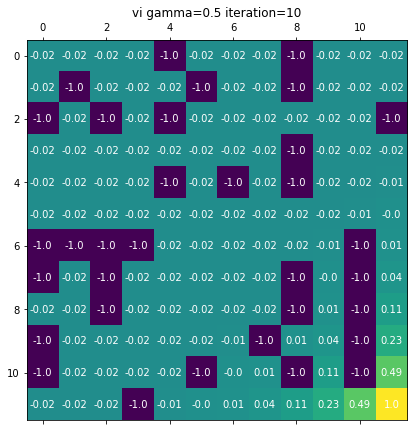

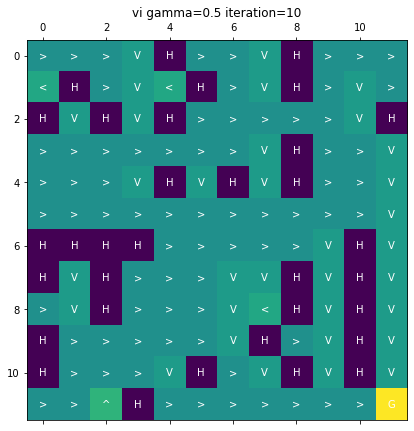

In [245]:
s = 0
d_reward = -0.01
plot_U(s=s, d_reward=d_reward, gamma=0.5, iters=[10], alg='vi', double_size=True)
plot_PI(s=s, d_reward=d_reward, gamma=0.5, iters=[10], alg='vi', double_size=True)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Last Utility, gamma=0.001 :
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Last Utility, gamma=0.8 :
ici [[  0.   0.   0.   1. -10.   0.   0.   1. -10.   0.   0.   0.]
 [  2. -10.   0.   0.   2. -10.   0.   1. -10.   0.   0.   0.]
 [-10.   1. -10.   1. -10.   0.   0.   0.   0.   0.   1. -10.]
 [  0.   0.   0.   0.   0.   0.   0.   1. -10.   0.   0.   0.]
 [  0.   0.   0.   1. -10.   1. -10.   1. -10.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [-10. -10. -10. -10.   0.   0.   0.   0.   0.   1. -10.   1.]
 [-10.   1. -10.   0.   0.   0.   0.   1. -10.   1. -10.   1.]
 [  0.   1. -10.   0.   0.   0.   0.   2. -10.   1. -10.   1.]
 [-10.   0.   0.   0.   0.   0.   1. -10.   0.   1. -10.   1.]
 [-10.   0.   0.   0.   1. -10.   0.   1. -10.   1. -10.   1.]
 [  0.   0.   1. -10.   0.   0.   0.   0.   0.   0.   0.  10.]]
ici [[  0.   0.   0.   1. -10.   0.   0.   1. -10.   0.   1.   1.]
 [  2. -10.   0.

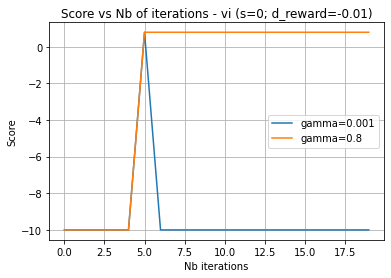

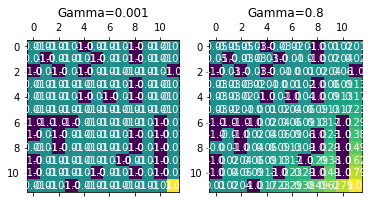

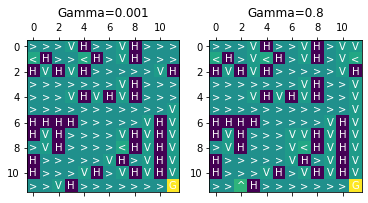

In [171]:
s = 0
d_reward = -0.01
gammas = [0.001, 0.8]
plot_score_vs_iteration(s=s, d_reward=d_reward, gammas=gammas, nb_iter=20, alg='vi', double_size=True)

## Policy iteration

In [159]:
def policy_iteration(s, d_reward, gamma=0.5, nb_iter = 4, double_size=False):
    FLsize = 36
    PI = np.zeros((FLsize,)).astype(int).astype(str)
    PI[[13,14,16,22,23,25]] = '-10'
    U = np.zeros((FLsize,))
    U[[13,14,16,22,23,25]] = -1
    holesgain = (13,14,16,22,23,25,35)
    if double_size:
        FLsize=144
        PI = np.zeros((FLsize,)).astype(int).astype(str)
        PI[[4,8,13,17,20,24,26,28,35,44,52,54,56,72,73,74,75,82,84,86,92,94,98,104,106,108,115,118,115,118,120,125,128,130,135]] = '-10'
        U = np.zeros((FLsize,))
        U[[4,8,13,17,20,24,26,28,35,44,52,54,56,72,73,74,75,82,84,86,92,94,98,104,106,108,115,118,115,118,120,125,128,130,135]] = -1
        holesgain = holesgain_double
    PI[FLsize-1] = '10'
    U[FLsize-1] = 1
    fl = FL(s, d_reward, double_size)
    for _ in range(nb_iter):
        for p in range(FLsize):
            if p not in holesgain:
                maxi = 0
                fl.position = p
                action = int(PI[p])
                TRs = fl.transitions(action)
                for tr in TRs:
                    maxi += tr[0]*U[tr[1]]
                fl.rewards()
                U[p] = fl.reward + gamma * maxi
        actions = (0,1,2,3)
        for p in range(FLsize):
            if p not in holesgain:
                maxi = np.zeros((4,))
                fl.position = p
                for i,action in enumerate(actions):
                    TRs = fl.transitions(action)
                    for tr in TRs:
                        maxi[i] += tr[0]*U[tr[1]]
                PI[p] = str(np.argmax(maxi))
    return U, PI

In [160]:
U, PI = policy_iteration(0, 0.5, nb_iter = 10)
print(PI.reshape((6,6)))

[['0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0']
 ['1' '-10' '-10' '1' '-10' '0']
 ['0' '0' '0' '1' '-10' '-10']
 ['1' '-10' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '10']]


## Evaluation

9 10 12 9 10 12 

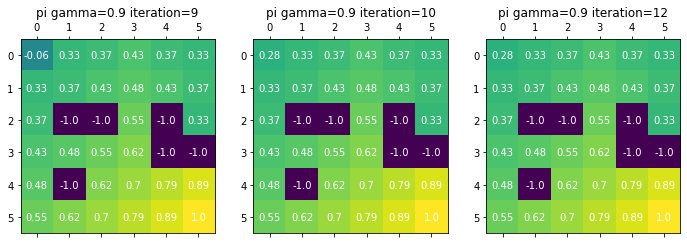

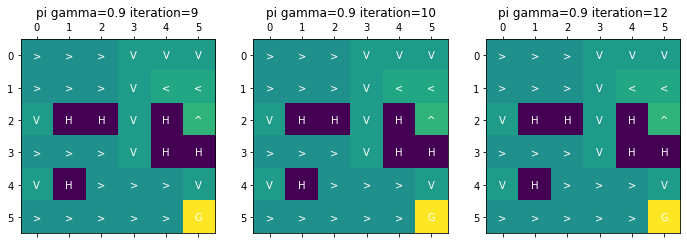

In [161]:
s = 0
d_reward = -0.01
plot_U(s=s, d_reward=d_reward, gamma=0.9, iters=[9, 10, 12], alg='pi')
plot_PI(s=s, d_reward=d_reward, gamma=0.9, iters=[9, 10, 12], alg='pi')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Last Utility, gamma=0.001 :
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Last Utility, gamma=0.5 :
ici [[  0.   0.   0.   1. -10.   0.   0.   1. -10.   0.   0.   0.]
 [  2. -10.   0.   0.   2. -10.   0.   1. -10.   0.   0.   0.]
 [-10.   1. -10.   1. -10.   0.   0.   0.   0.   0.   1. -10.]
 [  0.   0.   0.   0.   0.   0.   0.   1. -10.   0.   0.   0.]
 [  0.   0.   0.   1. -10.   1. -10.   1. -10.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [-10. -10. -10. -10.   0.   0.   0.   0.   0.   1. -10.   1.]
 [-10.   1. -10.   0.   0.   0.   0.   1. -10.   1. -10.   1.]
 [  0.   1. -10.   0.   0.   0.   0.   2. -10.   1. -10.   1.]
 [-10.   0.   0.   0.   0.   0.   1. -10.   0.   1. -10.   1.]
 [-10.   0.   0.   0.   1. -10.   0.   1. -10.   1. -10.   1.]
 [  0.   0.   1. -10.   0.   0.   0.   0.   0.   0.   0.  10.]]
ici [[  0.   0.   0.   1. -10.   0.   0.   1. -10.   0.   1.   1.]
 [  3. -10.   0.

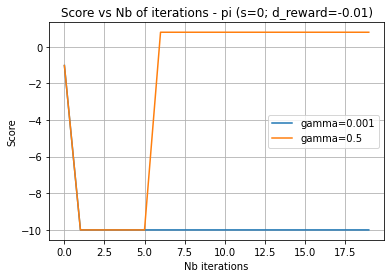

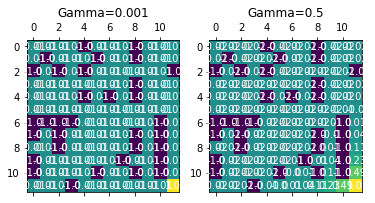

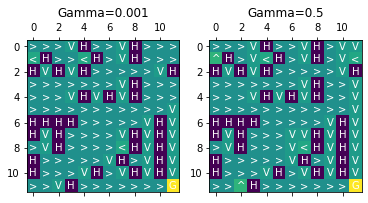

In [172]:
s = 0
d_reward = -0.01
gammas = [0.001, 0.5]
plot_score_vs_iteration(s=s, d_reward=d_reward, gammas=gammas, nb_iter=20, alg='pi', double_size=True)

# Time evaluation

In [248]:
def plot_time_vs_iteration(params, nb_iter):
    for param in params:
        print(param)
        s, d_rewards, gamma, double_size = param
        t_vi = np.zeros((nb_iter,))
        t_pi = np.zeros((nb_iter,))
        std_vi = np.zeros((nb_iter,))
        std_pi = np.zeros((nb_iter,))
        for i in range(nb_iter):
            temp_vi = []
            temp_pi = [] 
            for c in range(50):
                t1 = time.time()
                U = value_iteration(s, d_reward, gamma, i, double_size)
                PI = policy_from_value_iteration(s, d_reward, U, double_size)
                temp_vi.append(time.time()-t1)
                t1 = time.time()
                u = True
                U, PI = policy_iteration(s, d_reward, gamma, i, double_size)
                temp_pi.append(time.time()-t1)
            t_vi[i] = np.mean(temp_vi)
            t_pi[i] = np.mean(temp_pi)
            std_vi[i] = np.std(temp_vi)
            std_pi[i] = np.std(temp_pi)
        plt.title('Time (s) vs number of iterations')
        if double_size:
            plt.plot(range(nb_iter), t_vi, label='PI, s=' + str(s) + ' d_r=' + str(d_reward) + ' g=' + str(gamma) + ' 12x12', c='blue')
            plt.plot(range(nb_iter), t_pi, label='VI, s=' + str(s) + ' d_r=' + str(d_reward) + ' g=' + str(gamma) + ' 12x12', c='black')
        else:
            plt.plot(range(nb_iter), t_vi, label='PI, s=' + str(s) + ' d_r=' + str(d_reward) + ' g=' + str(gamma) + ' 6x6', c='green')
            plt.plot(range(nb_iter), t_pi, label='VI, s=' + str(s) + ' d_r=' + str(d_reward) + ' g=' + str(gamma) + ' 6x6', c='red')
        #plt.fill_between(range(nb_iter), t_vi-std_vi/2,t_vi+std_vi/2)
        #plt.fill_between(range(nb_iter), t_pi-std_pi/2,t_pi+std_pi/2)
    plt.legend()

[0, -0.01, 0.9, False]
[0.2, -0.5, 0.1, False]
[0.4, 1.0, 0.5, True]


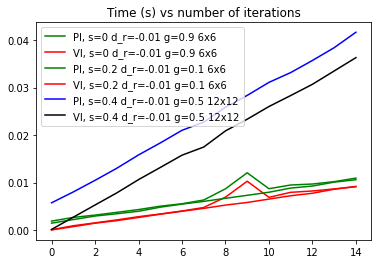

In [249]:
params = [[0, -0.01, 0.9, False], [0.2, -0.5, 0.1, False], [0.4, 1.0, 0.5, True]]
plot_time_vs_iteration(params=params, nb_iter=15)

# QLearning

In [251]:
def plot_score_vs_iteration_QL(s, d_reward, nb_iter, gammas, alphas, explorations, double_size=False):
    size = 6
    if double_size:
        size=12
    if nb_iter >= 100:
        iters = range(0,nb_iter, int(0.1*nb_iter))
    else:
        iters = range(nb_iter)
    means = np.zeros((len(iters),))
    stds= np.zeros((len(iters),))
    ts = np.zeros((len(iters),))
    store_U = []
    store_PI = []
    plt.figure()
    plt.title('Score vs Nb of iterations - ' + 'ql' + ' (s=' + str(s) + '; d_reward=' + str(d_reward) + ')')
    plt.grid()
    plt.ylabel('Score')
    plt.xlabel('Nb iterations')
    for c,gamma in enumerate(gammas):
        for alpha in alphas:
            for exploration in explorations:
                print(gamma, alpha, exploration)
                for index,i in enumerate(iters):
                    print(i, end=' ')
                    t1 = time.time()
                    Q = Qlearning(s, d_reward, gamma=gamma, nb_iter=i, alpha=alpha, exploration=exploration, double_size=double_size)
                    PI = policy_from_Q(Q, double_size=True)
                    ts[index] = time.time()-t1
                    means[index], stds[index] = evaluate_policy(s, d_reward, PI, double_size=double_size)
                if exploration == 'epsilon':
                    plt.plot(iters, means, label='g='+str(gamma)+' a='+str(alpha)+' '+str(exploration), c='black')
                else:
                    plt.plot(iters, means, label='g='+str(gamma)+' a='+str(alpha)+' '+str(exploration), c='red')
                plt.fill_between(iters, means-stds/2,means+stds/2)
                store_PI.append(PI.reshape((size,size)).astype(np.float))
    plt.legend()
    plt.figure()
    plt.title('Time vs Nb of iterations - ql')
    plt.grid()
    plt.ylabel('Time')
    plt.xlabel('Nb iterations')
    plt.plot(iters, ts)

In [225]:
def new_Q(Q, double_size=False):
    size= 6
    if double_size:
        size= 12
    Q = Q.reshape((size,size,4))
    n_Q = np.zeros((12,12))
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            n_Q[2*i,2*j] = Q[i,j,0]
            n_Q[2*i+1,2*j] = Q[i,j,1]
            n_Q[2*i,2*j+1] = Q[i,j,2]
            n_Q[2*i+1,2*j+1] = Q[i,j,3]
    return(n_Q)
    
def plot_visited_QL(s, d_reward, iters, gamma, exploration, alpha):
    print('La')
    fig = plt.figure(figsize=(16,7))
    for index,i in enumerate(iters):
            print(i, end=' ')
            Q, V = Qlearning(s=s, d_reward=d_reward, gamma=gamma, nb_iter=i, exploration=exploration, visited=True)
            PI = policy_from_Q(Q)
            ax = fig.add_subplot(1,len(iters)+1,index+1)
            ax.set_title('Nb visit - it '+str(i) +' '+str(exploration))
            #ax.set_title('Mean nb of time a state is visited - it '+str(i) + ' ga='+str(gamma)+' al='+str(alpha)+' '+str(exploration))
            #Q = new_Q(Q)
            V = V.reshape((6,6))
            print(V)
            V = vr(V)
            ax.matshow(V)
            for i in range(V.shape[0]):
                for j in range(V.shape[1]):
                    c = int(V[j,i])
                    ax.text(i, j, str(c), va='center', ha='center', c='white')
                    
def plot_PI_QL(s, d_reward, iters, gamma, exploration, alpha, double_size=False):
    print('Ici')
    size = 6
    if double_size:
        size=12
    fig = plt.figure(figsize=(16,7))
    for index,i in enumerate(iters):
            print(i, end=' ')
            print(d_reward)
            Q, V = Qlearning(s=s, d_reward=d_reward, gamma=gamma, alpha=alpha, nb_iter=i, exploration=exploration, visited=True, double_size=double_size)
            PI = policy_from_Q(Q, double_size=True)
            ax = fig.add_subplot(1,len(iters)+1,index+1)
            ax.set_title('Policy - it '+str(i) +' '+str(exploration))
            #Q = new_Q(Q, double_size)
            #Q = np.min(Q.reshape((6,6,4)), axis=2)
            #Q = vr(Q)
            PI = PI.reshape(size,size).astype(float)
            print(PI)
            ax.matshow(PI)
            PI = fr(PI.astype(np.int).astype(str))
            for i in range(PI.shape[0]):
                for j in range(PI.shape[1]):
                    c = PI[j,i]
                    ax.text(i, j, str(c), va='center', ha='center', c='white')

def plot_Q_QL(s, d_reward, iters, gamma, exploration, alpha):
    print('Ici')
    fig = plt.figure(figsize=(16,7))
    for index,i in enumerate(iters):
            print(i, end=' ')
            Q, V = Qlearning(s=s, d_reward=d_reward, gamma=gamma, nb_iter=i, exploration=exploration, visited=True)
            PI = policy_from_Q(Q)
            ax = fig.add_subplot(1,len(iters)+1,index+1)
            ax.set_title('maxQ by state- it '+str(i))
            #Q = new_Q(Q)
            #ax.set_title('maxQ by state- it '+str(i) + ' ga='+str(gamma)+' al='+str(alpha)+' '+str(exploration) + ' (s=' + str(s) + ' d_reward' + str(d_reward) + ')')
            #Q = new_Q(Q)
            Q = np.max(Q, axis=1)
            Q = Q.reshape((6,6))
            Q = vr(Q)
            ax.matshow(Q)
            for i in range(Q.shape[0]):
                for j in range(Q.shape[1]):
                    c = Q[j,i]
                    ax.text(i, j, str(c), va='center', ha='center', c='white')

## Q learning

In [226]:
def Qlearning(s, d_reward, gamma=0.5, nb_iter=9, alpha=0.1, exploration='epsilon', visited=False, double_size=False):
    # Initialisation
    FLsize = 36
    Q = np.zeros((FLsize,4))
    V = np.zeros((FLsize,))
    Q[[13,14,16,22,23,25],:] = -1
    if double_size:
        FLsize = 144
        Q = np.zeros((FLsize,4))
        V = np.zeros((FLsize,))
        Q[[4,8,13,17,20,24,26,28,35,44,52,54,56,72,73,74,75,82,84,86,92,94,98,104,106,108,115,118,115,118,120,125,128,130,135],:] = -1
    Q[FLsize-1,:] = 1
    fl = FL(s, d_reward, double_size)
    # Update
    for i in range(nb_iter):
        if fl.done == True:
            fl.reset()
        state = fl.position
        if exploration == 'epsilon':
            epsilon = (i+1)/nb_iter
        elif exploration == 'exploit':
            epsilon = 1
        elif exploration == 'explore':
            epsilon = 0
        if epsilon < random.random():
            action = random.randint(0,3)
        else:
            action = np.argmax(Q[state])  
        fl.step(action)
        fl.reward
        V[state] += 1
        Q[state,action] = (1-alpha)*Q[state,action] + alpha*(fl.reward+gamma*np.max(Q[fl.position]))
    if visited:
        return Q,V
    return Q

def policy_from_Q(Q, double_size=False):
    PI = np.argmax(Q, axis=1).astype(str)
    if double_size:
        FLsize=144
        PI[[4,8,13,17,20,24,26,28,35,44,52,54,56,72,73,74,75,82,84,86,92,94,98,104,106,108,115,118,115,118,120,125,128,130,135]] = -10
    else:
        FLsize=36
        PI[[13,14,16,22,23,25]] = -10
    PI[FLsize-1] = 10
    return PI

In [227]:
Q = Qlearning(s=0, d_reward=-0.04, nb_iter=10000, alpha = 0.5, double_size=True)
PI = policy_from_Q(Q, double_size=True)
print(PI.reshape((12,12)))

[['0' '0' '1' '2' '-10' '0' '0' '1' '-10' '3' '3' '3']
 ['3' '-10' '0' '0' '2' '-10' '1' '2' '-10' '0' '1' '0']
 ['-10' '1' '-10' '1' '-10' '0' '3' '2' '2' '3' '3' '-10']
 ['2' '2' '2' '1' '0' '1' '0' '3' '-10' '1' '3' '0']
 ['2' '3' '1' '1' '-10' '1' '-10' '1' '-10' '3' '3' '3']
 ['2' '2' '0' '2' '0' '3' '0' '1' '0' '2' '0' '1']
 ['-10' '-10' '-10' '-10' '1' '1' '2' '3' '0' '1' '-10' '1']
 ['-10' '2' '-10' '1' '1' '1' '1' '2' '-10' '1' '-10' '1']
 ['0' '3' '-10' '1' '3' '1' '1' '3' '-10' '1' '-10' '1']
 ['-10' '1' '0' '1' '2' '3' '2' '-10' '3' '1' '-10' '1']
 ['-10' '0' '1' '2' '3' '-10' '1' '1' '-10' '1' '-10' '1']
 ['1' '0' '1' '-10' '3' '2' '1' '0' '0' '0' '0' '10']]


# Evaluation

0.5 0.5 exploit
0 20000 40000 60000 80000 100000 120000 140000 160000 180000 0.5 0.5 explore
0 20000 40000 60000 80000 100000 120000 140000 160000 180000 0.5 0.5 epsilon
0 20000 40000 60000 80000 100000 120000 140000 160000 180000 

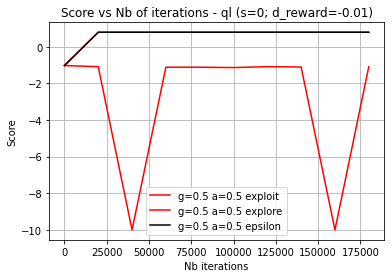

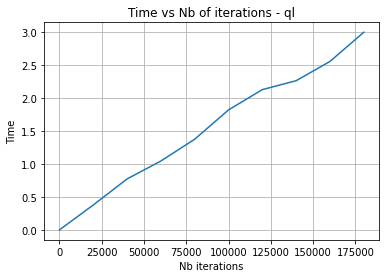

In [252]:
s = 0
d_reward = -0.01
explorations = ['exploit', 'explore', 'epsilon']
alphas = [0.5]
gammas = [0.5]
plot_score_vs_iteration_QL(s=s, d_reward=d_reward, gammas=gammas, alphas=alphas, explorations=explorations, nb_iter=200000, double_size=True)

Ici
1000000 -0.01
[[  0.   0.   0.   1. -10.   3.   0.   1. -10.   3.   1.   0.]
 [  2. -10.   0.   1.   2. -10.   0.   1. -10.   1.   1.   0.]
 [-10.   1. -10.   1. -10.   0.   0.   0.   0.   0.   1. -10.]
 [  0.   0.   0.   0.   0.   0.   0.   1. -10.   0.   0.   1.]
 [  0.   0.   0.   1. -10.   1. -10.   1. -10.   1.   0.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [-10. -10. -10. -10.   0.   0.   0.   0.   0.   1. -10.   1.]
 [-10.   1. -10.   1.   1.   0.   1.   1. -10.   1. -10.   1.]
 [  2.   3. -10.   1.   1.   1.   1.   2. -10.   1. -10.   1.]
 [-10.   3.   2.   2.   1.   0.   1. -10.   0.   1. -10.   1.]
 [-10.   3.   2.   2.   1. -10.   0.   1. -10.   1. -10.   1.]
 [  0.   2.   3. -10.   0.   0.   0.   0.   0.   0.   0.  10.]]


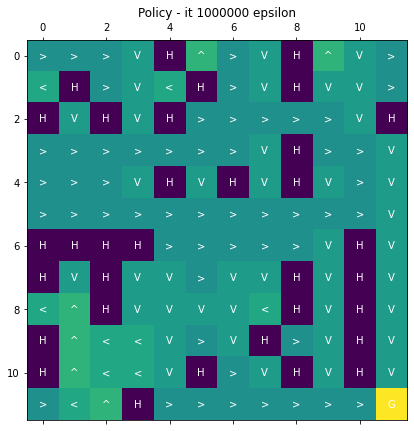

In [253]:
s=0
d_reward=-0.01
gamma = 0.1
alpha = 0.5
exploration='epsilon'
iters = [1000000]
plot_PI_QL(s=s, d_reward=d_reward, gamma=gamma, alpha=alpha, exploration=exploration, iters=iters, double_size=True)

In [235]:
def plot_time_vs_iteration_QL(params, nb_iter):
    iters = range(1, nb_iter, int(nb_iter/10))
    for param in params:
        s, d_rewards, gamma, double_size = param
        t_qi_explore = np.zeros((len(iters),))
        t_qi_epsilon = np.zeros((len(iters),))
        t_qi_exploit = np.zeros((len(iters),))
        for index,i in enumerate(iters):
            print(i)
            temp_qi_explore = []
            temp_qi_epsilon = [] 
            temp_qi_exploit = []
            for c in range(10):
                t1 = time.time()
                Q = Qlearning(s=s, d_reward=d_reward, gamma=gamma, nb_iter=i, exploration='exploit', double_size=double_size)
                PI = policy_from_Q(Q)
                temp_qi_exploit.append(time.time()-t1)
                t1 = time.time()
                Q = Qlearning(s=s, d_reward=d_reward, gamma=gamma, nb_iter=i, exploration='epsilon', double_size=double_size)
                PI = policy_from_Q(Q)
                temp_qi_epsilon.append(time.time()-t1)
                t1 = time.time()
                Q = Qlearning(s=s, d_reward=d_reward, gamma=gamma, nb_iter=i, exploration='explore', double_size=double_size)
                PI = policy_from_Q(Q)
                temp_qi_explore.append(time.time()-t1)
            t_qi_exploit[index] = np.mean(temp_qi_exploit)
            t_qi_epsilon[index] = np.mean(temp_qi_epsilon)
            t_qi_explore[index] = np.mean(temp_qi_explore)
        plt.title('Time vs number of iterations')
        if double_size:
            plt.plot(iters, t_qi_exploit, label='s=' + str(s) + ' d_r=' + str(d_reward) + ' g=' + str(gamma) + ' exploit' + ' 12x12')
        else:
            plt.plot(iters, t_qi_exploit, label='s=' + str(s) + ' d_r=' + str(d_reward) + ' g=' + str(gamma) + ' exploit' + ' 6x6')
        #plt.fill_between(range(nb_iter), t_vi-std_vi/2,t_vi+std_vi/2)
        if double_size:
            plt.plot(iters, t_qi_epsilon, label='s=' + str(s) + ' d_r=' + str(d_reward) + ' g=' + str(gamma) + ' epsilon' + ' 12x12')
        else:
            plt.plot(iters, t_qi_epsilon, label='s=' + str(s) + ' d_r=' + str(d_reward) + ' g=' + str(gamma) + ' epsilon' + ' 6x6')
        #plt.fill_between(range(nb_iter), t_pi-std_pi/2,t_pi+std_pi/2)
        if double_size:
            plt.plot(iters, t_qi_explore, label='s=' + str(s) + ' d_r=' + str(d_reward) + ' g=' + str(gamma) + ' explore' + ' 12x12')
        else;
            plt.plot(iters, t_qi_explore, label='s=' + str(s) + ' d_r=' + str(d_reward) + ' g=' + str(gamma) + ' explore' + ' 6x6')
    plt.legend()

SyntaxError: invalid syntax (<ipython-input-235-56a215022785>, line 42)

1
1001
2001
3001
4001
5001
6001
7001
8001
9001
1
1001
2001
3001
4001
5001
6001
7001
8001
9001
1
1001
2001
3001
4001
5001
6001
7001
8001
9001


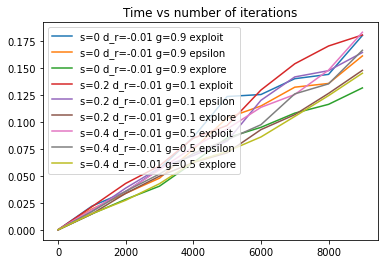

In [236]:
params = [[0, -0.01, 0.9, False], [0.2, -0.5, 0.1, False], [0.4, 1.0, 0.5, True]]
plot_time_vs_iteration_QL(params=params, nb_iter=10000)

# Never Give Up

In [257]:
class NeverGiveUp:
    
    def __init__(self, slippery=0, d_reward=-1, nb_states=1000):
        self.slippery = slippery
        self.state = 0
        self.done = False
        self.d_reward = d_reward
        self.nb_states = nb_states
        
    def reset(self):
        self.state = 0
        self.done = False
        
    def evaluate_reward(self):
        if self.nb_states == 1000:
            if self.state == 1000:
                self.done = True
                return 0
            if self.state == 999:
                return 999
            if self.state == 99:
                return 99
            if self.state == 9:
                return 9
            else:
                return self.d_reward
        else:
            if self.state == 10000:
                self.done = True
                return 0
            if self.state == 9999:
                return 9999
            if self.state == 999:
                return 999
            if self.state == 99:
                return 99
            if self.state == 9:
                return 9
            else:
                return self.d_reward
        
    def next_state(self, action):
        if self.nb_states == 1000:
            if action == 0:
                return 1000
            if action == 1 and self.state < 999:
                return self.state+1
            if action == 2 and self.state < 998:
                return self.state+2
            return 1000
        else:
            if action == 0:
                return 10000
            if action == 1 and self.state < 9999:
                return self.state+1
            if action == 2 and self.state < 9998:
                return self.state+2
            return 10000
    
    def transitions(self, action):
        return ((1-self.slippery,self.next_state(action)),(self.slippery/2,self.next_state((action+1)%3)),(self.slippery/2,self.next_state((action+2)%3)))
    
    def step(self, action):
        TR = self.transitions(action)
        r = random.random()
        counter = 0
        for tr in TR:
            counter += tr[0]
            if r <= counter:
                self.state = tr[1]
                break
        return self.evaluate_reward()

In [258]:
pn = NeverGiveUp(slippery=0)
while pn.done == False:
    choice = random.randint(0,2)
    print("action: ", choice)
    r = pn.step(choice)
    print("state: ", pn.state, "reward: ", r)

action:  0
state:  1000 reward:  0


## Value iteration

In [259]:
def value_iteration(s=0, d_reward=-1, gamma=0.999, nb_iter=500, nb_states=1000):
    pn = NeverGiveUp(slippery=s, d_reward=d_reward, nb_states=nb_states)
    U = np.zeros(nb_states+1).astype(np.float)
    for _ in range(nb_iter):
        for state in range(nb_states):
            pn.state = state
            maxi = np.zeros((3,)).astype(np.float)
            for i, action in enumerate(range(3)):
                TRs = pn.transitions(action)
                for tr in TRs:
                    maxi[i] += tr[0]*U[tr[1]]
            U[state] = pn.evaluate_reward()+gamma*np.max(maxi)
    return U
    
U = value_iteration()
#print(U[:-1].reshape((100,10)))

In [260]:
def policy_from_value_iteration(s, d_reward, U, nb_states=1000):
    PI = np.zeros(nb_states+1).astype(int).astype(str)
    PI[-1] = 'End'
    actions = (0,1,2)
    pn = NeverGiveUp(s, d_reward, nb_states=nb_states)
    for state in range(nb_states):
        maxi = np.zeros((3,))
        pn.state = state
        for i,action in enumerate(actions):
            TRs = pn.transitions(action)
            for tr in TRs:
                maxi[i] += tr[0]*U[tr[1]]
        PI[state] = str(np.argmax(maxi))
    return PI

PI = policy_from_value_iteration(0,-1,U)
#print(PI[:-1].reshape(100,10))

# Evaluation

In [261]:
def evaluate_policy(s, d_reward, PI, nb_states=1000):
    Rs = np.zeros((1,))
    for i in range(1):
        pn = NeverGiveUp(s, d_reward, nb_states)
        R = 0
        while pn.done == False and R > -100000 and R < 100000:
            a = int(PI[pn.state])
            pn.step(a)
            R += pn.evaluate_reward()
        Rs[i] = R
    return np.mean(Rs), np.std(Rs)

In [262]:
def plot_score_vs_iteration(s, d_reward, nb_iter, gammas, alg, alpha=0.5, exploration='epsilon', nb_states=1000):
    if nb_iter >= 100:
        iters = range(0,nb_iter, int(0.1*nb_iter))
    else:
        iters = range(nb_iter)
    means = np.zeros((len(iters),))
    stds= np.zeros((len(iters),))
    store_U = []
    store_PI = []
    plt.figure()
    plt.title('Score vs Nb of iterations - ' + str(alg) + ' (s=' + str(s) + '; d_reward=' + str(d_reward) + ')')
    plt.grid()
    plt.ylabel('Score')
    plt.xlabel('Nb iterations')
    for c,gamma in enumerate(gammas):
        for index,i in enumerate(iters):
            print(i, end=' ')
            if alg == 'vi':
                U = value_iteration(s, d_reward, gamma, i, nb_states)
                PI = policy_from_value_iteration(s, d_reward, U, nb_states)
            if alg == 'pi':
                U, PI = policy_iteration(s, d_reward, gamma, i, nb_states)
            means[index], stds[index] = evaluate_policy(s, d_reward, PI, nb_states)
        plt.plot(iters, means, label='gamma='+str(gamma))
        plt.fill_between(iters, means-stds/2,means+stds/2)
        store_U.append(U)
        store_PI.append(PI)
    plt.legend()
    fig = plt.figure(figsize=(6,10))
    for c,gamma in enumerate(gammas):
        ax = fig.add_subplot(1,3,c+1)
        PI = store_PI[c]
        if nb_states == 1000:
            PI = PI[:-1].reshape((50,20)).astype(np.float)
        else:
            PI = PI[:-1].reshape((200,50)).astype(np.float)
        ax.set_title('Policy, g='+str(gamma)+' '+str(alg))
        ax.matshow(PI)
    fig = plt.figure(figsize=(6,10))
    for c,gamma in enumerate(gammas):
        ax = fig.add_subplot(1,3,c+1)
        U = store_U[c]
        if nb_states == 1000:
            U = U[:-1].reshape((50,20)).astype(np.float)
        else:
            U = U[:-1].reshape((200,50)).astype(np.float)
        ax.set_title('Utility, g='+str(gamma)+' '+str(alg))
        ax.matshow(U)

In [263]:
def plot_U(s, d_reward, iters, gamma, alg, nb_states=1000):
    fig = plt.figure(figsize=(16,7))
    for index,i in enumerate(iters):
            print(i, end=' ')
            if alg == 'vi':
                U = value_iteration(s, d_reward, gamma, i, nb_states)
                PI = policy_from_value_iteration(s, d_reward, U, nb_states)
            if alg == 'pi':
                U, PI = policy_iteration(s, d_reward, gamma, i, nb_states)
            if alg == 'ql':
                Q = Qlearning(s, d_reward, gamma, i, nb_states)
                PI = policy_from_Q(Q)
            ax = fig.add_subplot(1,len(iters)+1,index+1)
            ax.set_title(str(alg)+' gamma='+str(gamma)+' iteration='+str(i))
            if nb_states == 1000:
                U = U[:-1].reshape((50,20))
            else:
                U = U[:-1].reshape((200,50))
            ax.matshow(U)

def plot_PI(s, d_reward, iters, gamma, alg, nb_states):
    fig = plt.figure(figsize=(16,7))
    for index,i in enumerate(iters):
            print(i, end=' ')
            if alg == 'vi':
                U = value_iteration(s, d_reward, gamma, i, nb_states)
                PI = policy_from_value_iteration(s, d_reward, U, nb_states)
            if alg == 'pi':
                U, PI = policy_iteration(s, d_reward, gamma, i, nb_states)
            if alg == 'ql':
                Q = Qlearning(s, d_reward, gamma, i, nb_states)
                PI = policy_from_Q(Q)
            ax = fig.add_subplot(1,len(iters)+1,index+1)
            ax.set_title(str(alg)+' gamma='+str(gamma)+' iteration='+str(i))
            if nb_states == 1000:
                PI = PI[:-1].reshape((50,20)).astype(np.float)
            else:
                PI = PI[:-1].reshape((200,50)).astype(np.float)
            ax.matshow(PI)
            PI = PI.astype(int)

4 5 6 

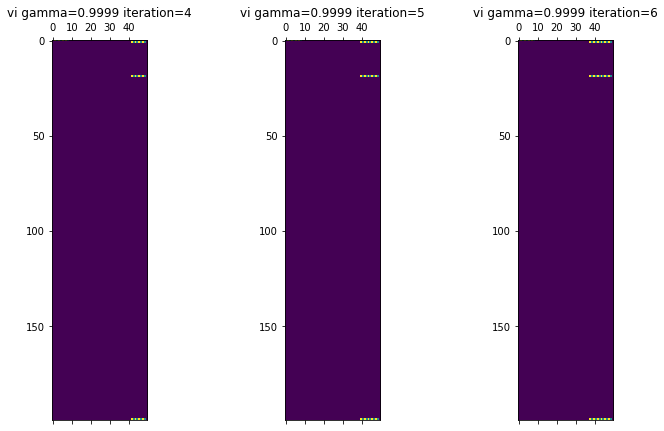

In [264]:
s = 0
d_reward = -1
gamma = 0.9999
plot_PI(s=s, d_reward=d_reward, iters=[4, 5, 6], gamma=gamma, alg='vi', nb_states=10000)

0 100 200 

KeyboardInterrupt: 

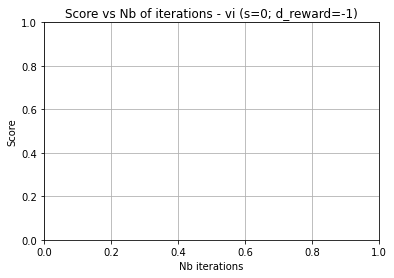

In [267]:
s = 0
d_reward = -1
gammas = [0.999999]
plot_score_vs_iteration(s=s, d_reward=d_reward, gammas=gammas, nb_iter=1000, alg='vi', nb_states=10000)

0 10 20 30 40 50 60 70 80 90 0 10 20 30 40 50 60 70 80 90 

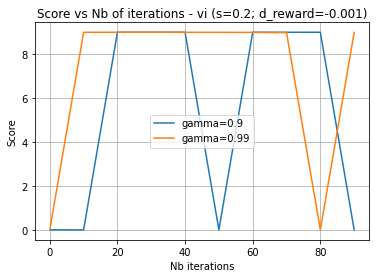

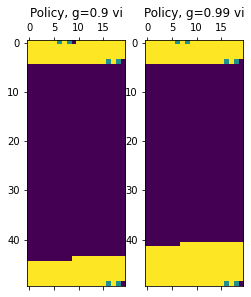

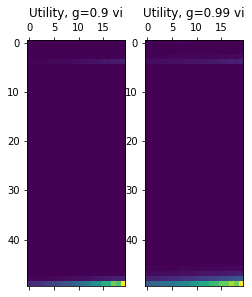

In [28]:
s = 0.2
d_reward = -0.001
gammas = [0.9, 0.99]
plot_score_vs_iteration(s=s, d_reward=d_reward, gammas=gammas, nb_iter=100, alg='vi')

## Policy iteration

In [273]:
def policy_iteration(s, d_reward, gamma=0.999, nb_iter = 500, nb_states=1000):
    PI = np.zeros(nb_states+1).astype(int).astype(str)
    U = np.zeros(nb_states+1).astype(np.float)
    pn = NeverGiveUp(s, d_reward, nb_states)
    for _ in range(nb_iter):
        for state in range(nb_states):
            maxi = 0
            pn.state = state
            action = int(PI[state])
            TRs = pn.transitions(action)
            for tr in TRs:
                maxi += tr[0]*U[tr[1]]
            U[state] = pn.evaluate_reward() + gamma * maxi
        actions = (0,1,2)
        for state in range(nb_states):
            maxi = np.zeros((3,))
            pn.state = state
            for i,action in enumerate(actions):
                TRs = pn.transitions(action)
                for tr in TRs:
                    maxi[i] += tr[0]*U[tr[1]]
            PI[state] = str(np.argmax(maxi))
    return U, PI

PI = policy_iteration(0, 0.99)
#print(PI[:-1].reshape(100,10))

0 100 200 300 400 500 600 700 800 900 

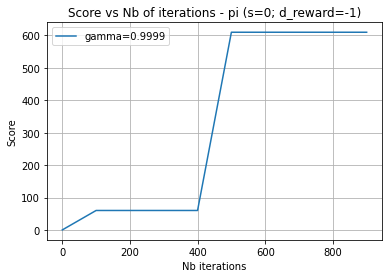

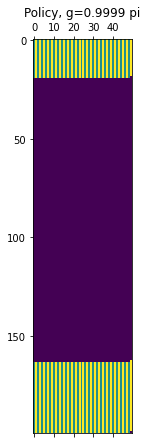

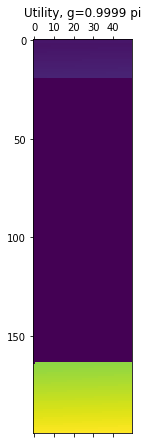

In [288]:
s = 0
d_reward = -1
gammas = [0.9999]
plot_score_vs_iteration(s=s, d_reward=d_reward, gammas=gammas, nb_iter=1000, alg='pi', nb_states=10000)

0 80 160 240 320 400 480 560 640 720 0 80 160 240 320 400 480 560 640 720 0 80 160 240 320 400 480 560 640 720 

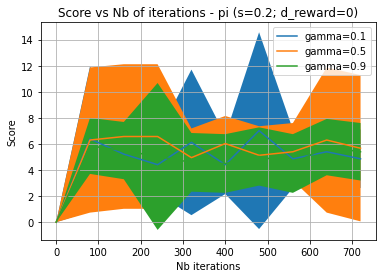

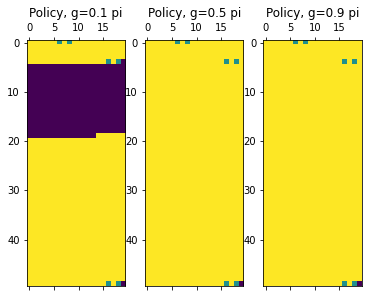

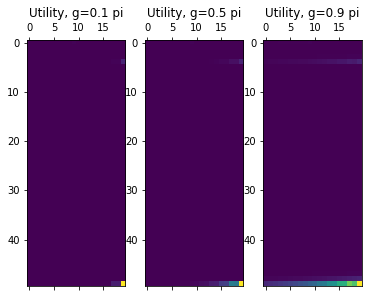

In [41]:
s = 0.2
d_reward = 0
gammas = [0.1, 0.5, 0.9]
plot_score_vs_iteration(s=s, d_reward=d_reward, gammas=gammas, nb_iter=800, alg='pi')

In [285]:
def plot_time_vs_iteration(params, nb_iter):
    for param in params:
        print(param)
        s, d_rewards, gamma, nb_states = param
        iters = range(1, nb_iter, int(nb_iter/10))
        t_vi = np.zeros((len(iters),))
        t_pi = np.zeros((len(iters),))
        std_vi = np.zeros((len(iters),))
        std_pi = np.zeros((len(iters),))
        for index, i in enumerate(range(1, nb_iter, int(nb_iter/10))):
            temp_vi = []
            temp_pi = [] 
            for c in range(1):
                t1 = time.time()
                U = value_iteration(s, d_reward, gamma, i, nb_states)
                PI = policy_from_value_iteration(s, d_reward, U, nb_states)
                temp_vi.append(time.time()-t1)
                t1 = time.time()
                t1 = time.time()
                u = True
                U, PI = policy_iteration(s, d_reward, gamma, i, nb_states)
                temp_pi.append(time.time()-t1)
            t_vi[index] = np.mean(temp_vi)
            t_pi[index] = np.mean(temp_pi)
            std_vi[index] = np.std(temp_vi)
            std_pi[index] = np.std(temp_pi)
        plt.title('Time vs number of iterations')
        if nb_states == 1000:
            plt.plot(range(1, nb_iter, int(nb_iter/10)), t_vi, label='PI, s=' + str(s) + ' d_r=' + str(d_reward) + ' g=' + str(gamma) + ' states=1e3', c='blue')
        else:
            plt.plot(range(1, nb_iter, int(nb_iter/10)), t_vi, label='PI, s=' + str(s) + ' d_r=' + str(d_reward) + ' g=' + str(gamma) + ' states=1e4', c='black')
        #plt.fill_between(range(nb_iter), t_vi-std_vi/2,t_vi+std_vi/2)
        if nb_states == 1000:
            plt.plot(range(1, nb_iter, int(nb_iter/10)), t_pi, label='VI, s=' + str(s) + ' d_r=' + str(d_reward) + ' g=' + str(gamma) + ' states=1e3', c='green')
        else:
            plt.plot(range(1, nb_iter, int(nb_iter/10)), t_pi, label='VI, s=' + str(s) + ' d_r=' + str(d_reward) + ' g=' + str(gamma) + ' states=1e4', c='yellow')
        #plt.fill_between(range(nb_iter), t_pi-std_pi/2,t_pi+std_pi/2)
    plt.legend()

[0, -1, 0.9, 1000]
[0.2, 0, 0.1, 1000]
[0.4, 1, 0.5, 10000]


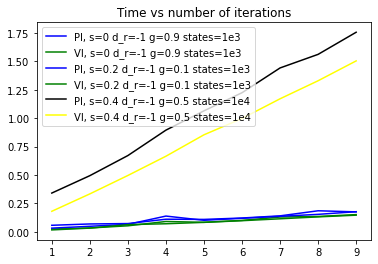

In [286]:
params = [[0, -1, 0.9, 1000], [0.2, 0, 0.1, 1000], [0.4, 1, 0.5, 10000]]
plot_time_vs_iteration(params=params, nb_iter=10)

## Q learning

In [211]:
def Qlearning(s, d_reward, gamma=0.999, nb_iter=100, alpha=0.1, exploration='epsilon', visited=False):
    # Initialisation
    Q = np.zeros((1001,3))
    V = np.zeros((1000,))
    pn = PalindromicNumber(s, d_reward)
    # Update
    for i in range(nb_iter):
        if pn.done == True:
            pn.reset()
        state = pn.state
        if exploration == 'epsilon':
            epsilon = (i+1)/nb_iter
        elif exploration == 'exploit':
            epsilon = 1
        elif exploration == 'explore':
            epsilon = 0
        if epsilon < random.random():
            if random.random() < 0.05
            action = random.randint(1,2)
        else:
            action = np.argmax(Q[state])  
        pn.step(action)
        V[state] += 1
        Q[state,action] = (1-alpha)*Q[state,action] + alpha*(pn.evaluate_reward()+gamma*np.max(Q[pn.state]))
    if visited:
        return Q, V
    return Q

def policy_from_Q(Q):
    PI = np.argmax(Q, axis=1).astype(str)
    PI[1000] = "End"
    return PI

Q = Qlearning(s=0, d_reward=-1, nb_iter=10000, exploration='epsilon')
#print(Q)
PI = policy_from_Q(Q)
print(PI[:10])

['2' '2' '2' '2' '2' '2' '2' '2' '1' '0']


In [218]:
def plot_score_vs_iteration_QL(s, d_reward, nb_iter, gammas, alphas, explorations):
    if nb_iter >= 100:
        iters = range(0,nb_iter, int(0.1*nb_iter))
    else:
        iters = range(nb_iter)
    means = np.zeros((len(iters),))
    stds= np.zeros((len(iters),))
    ts = np.zeros((len(iters),))
    store_U = []
    store_PI = []
    plt.figure()
    plt.title('Score vs Nb of iterations - ' + 'ql' + ' (s=' + str(s) + '; d_reward=' + str(d_reward) + ')')
    plt.grid()
    plt.ylabel('Score')
    plt.xlabel('Nb iterations')
    for c,gamma in enumerate(gammas):
        for alpha in alphas:
            for exploration in explorations:
                print(gamma, alpha, exploration)
                for index,i in enumerate(iters):
                    print(i, end=' ')
                    Q = Qlearning(s, d_reward, gamma=gamma, nb_iter=i, alpha=alpha, exploration=exploration)
                    PI = policy_from_Q(Q)
                    means[index], stds[index] = evaluate_policy(s, d_reward, PI)
                if alpha > 0.2 and gamma :
                    plt.plot(iters, means, label='g='+str(gamma)+' a='+str(alpha)+' '+str(exploration), c='black')
                else:
                    plt.plot(iters, means, label='g='+str(gamma)+' a='+str(alpha)+' '+str(exploration), c='red')
                plt.fill_between(iters, means-stds/2,means+stds/2)
                store_PI.append(PI[:-1].reshape((50,20)).astype(np.float))
    plt.legend()

In [212]:
def new_Q(Q):
    Q = Q.reshape((6,6,4))
    n_Q = np.zeros((12,12))
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            n_Q[2*i,2*j] = Q[i,j,0]
            n_Q[2*i+1,2*j] = Q[i,j,1]
            n_Q[2*i,2*j+1] = Q[i,j,2]
            n_Q[2*i+1,2*j+1] = Q[i,j,3]
    return(n_Q)
    
def plot_visited_QL(s, d_reward, iters, gamma, exploration, alpha):
    print('La')
    fig = plt.figure(figsize=(16,7))
    for index,i in enumerate(iters):
            print(i, end=' ')
            Q, V = Qlearning(s=s, d_reward=d_reward, gamma=gamma, nb_iter=i, exploration=exploration, visited=True)
            PI = policy_from_Q(Q)
            ax = fig.add_subplot(1,len(iters)+1,index+1)
            ax.set_title('Nb visit - it '+str(i) +' '+str(exploration))
            V = V.reshape((50,20))
            V = vr(V)
            ax.matshow(V)
                    
def plot_PI_QL(s, d_reward, iters, gamma, exploration, alpha):
    print('Ici')
    fig = plt.figure(figsize=(16,7))
    for index,i in enumerate(iters):
            print(i, end=' ')
            print(d_reward)
            Q = Qlearning(s=s, d_reward=d_reward, gamma=gamma, alpha=alpha, nb_iter=i, exploration=exploration)
            PI = policy_from_Q(Q)
            ax = fig.add_subplot(1,len(iters)+1,index+1)
            ax.set_title('Policy - it '+str(i) +' '+str(exploration))
            PI = PI[:-1].reshape(50,20).astype(float)
            ax.matshow(PI.astype(np.int))
            PI = PI.astype(np.int).astype(str)

def plot_Q_QL(s, d_reward, iters, gamma, exploration, alpha):
    print('Ici')
    fig = plt.figure(figsize=(16,7))
    for index,i in enumerate(iters):
            print(i, end=' ')
            Q, V = Qlearning(s=s, d_reward=d_reward, gamma=gamma, nb_iter=i, exploration=exploration, visited=True)
            PI = policy_from_Q(Q)
            ax = fig.add_subplot(1,len(iters)+1,index+1)
            ax.set_title('maxQ by state- it '+str(i))
            Q = np.max(Q, axis=1)
            Q = Q.reshape((6,6))
            Q = vr(Q)
            ax.matshow(Q)
            for i in range(Q.shape[0]):
                for j in range(Q.shape[1]):
                    c = Q[j,i]
                    ax.text(i, j, str(c), va='center', ha='center', c='white')

0.999 0.9 explore
0 100000 200000 300000 400000 500000 600000 700000 800000 900000 0.999 0.9 epsilon
0 100000 200000 300000 400000 500000 600000 700000 800000 900000 0.999 0.9 exploit
0 100000 200000 300000 400000 500000 600000 700000 800000 900000 

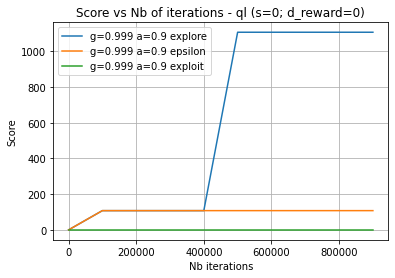

In [239]:
s = 0
d_reward = 0
explorations = ['explore', 'epsilon', 'exploit']
alphas = [0.9]
gammas = [0.999]
plot_score_vs_iteration_QL(s=s, d_reward=d_reward, gammas=gammas, alphas=alphas, explorations=explorations, nb_iter=1000000)

Ici
1000000 0


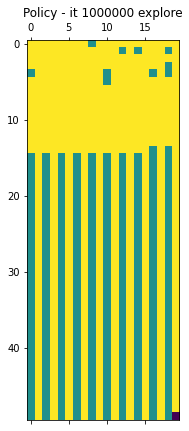

In [238]:
s=0
d_reward=0
gamma = 0.99999
alpha = 0.9
exploration='explore'
iters = [1000000]
plot_PI_QL(s=s, d_reward=d_reward, gamma=gamma, alpha=alpha, exploration=exploration, iters=iters)

In [240]:
def plot_time_vs_iteration_QL(params, nb_iter):
    iters = range(1, nb_iter, int(nb_iter/10))
    for param in params:
        s, d_rewards, gamma = param
        t_qi_explore = np.zeros((len(iters),))
        t_qi_epsilon = np.zeros((len(iters),))
        t_qi_exploit = np.zeros((len(iters),))
        for index,i in enumerate(iters):
            print(i)
            temp_qi_explore = []
            temp_qi_epsilon = [] 
            temp_qi_exploit = []
            for c in range(10):
                t1 = time.time()
                Q = Qlearning(s=s, d_reward=d_reward, gamma=gamma, nb_iter=i, exploration='exploit')
                PI = policy_from_Q(Q)
                temp_qi_exploit.append(time.time()-t1)
                t1 = time.time()
                Q = Qlearning(s=s, d_reward=d_reward, gamma=gamma, nb_iter=i, exploration='epsilon')
                PI = policy_from_Q(Q)
                temp_qi_epsilon.append(time.time()-t1)
                t1 = time.time()
                Q = Qlearning(s=s, d_reward=d_reward, gamma=gamma, nb_iter=i, exploration='explore')
                PI = policy_from_Q(Q)
                temp_qi_explore.append(time.time()-t1)
            t_qi_exploit[index] = np.mean(temp_qi_exploit)
            t_qi_epsilon[index] = np.mean(temp_qi_epsilon)
            t_qi_explore[index] = np.mean(temp_qi_explore)
        plt.title('Time vs number of iterations')
        plt.plot(iters, t_qi_exploit, label='s=' + str(s) + ' d_r=' + str(d_reward) + ' g=' + str(gamma) + ' exploit')
        #plt.fill_between(range(nb_iter), t_vi-std_vi/2,t_vi+std_vi/2)
        plt.plot(iters, t_qi_epsilon, label='s=' + str(s) + ' d_r=' + str(d_reward) + ' g=' + str(gamma) + ' epsilon')
        #plt.fill_between(range(nb_iter), t_pi-std_pi/2,t_pi+std_pi/2)
        plt.plot(iters, t_qi_explore, label='s=' + str(s) + ' d_r=' + str(d_reward) + ' g=' + str(gamma) + ' explore')
    plt.legend()

1
10001
20001
30001
40001
50001
60001
70001
80001
90001
1
10001
20001
30001
40001
50001
60001
70001
80001
90001
1
10001
20001
30001
40001
50001
60001
70001
80001
90001


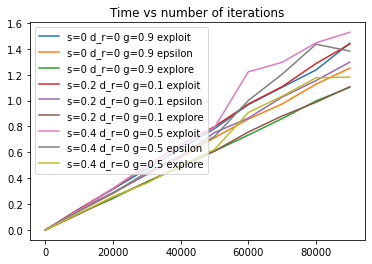

In [242]:
params = [[0, -0.01, 0.9], [0.2, -0.5, 0.1], [0.4, 1.0, 0.5]]
plot_time_vs_iteration_QL(params=params, nb_iter=100000)

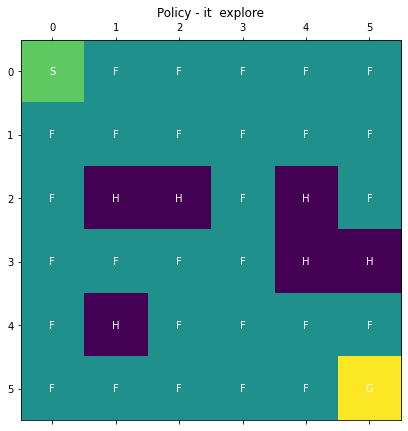

In [269]:
FroLake = np.array([['S', 'F', 'F', 'F', 'F', 'F'],['F', 'F', 'F', 'F', 'F', 'F'],['F', 'H', 'H', 'F', 'H', 'F'],
          ['F', 'F', 'F', 'F', 'H', 'H'],['F', 'H', 'F', 'F', 'F', 'F'],['F', 'F', 'F', 'F', 'F', 'G']])
FroLake2 = np.zeros((36,))
FroLake2[-1] = 10
FroLake2[[13,14,16,22,23,25]] = -10
FroLake2[0] = 5
FroLake2 = FroLake2.reshape((6,6))
fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot(1,len(iters)+1,1)
ax.set_title('Policy - it ' +' '+str(exploration))
ax.matshow(FroLake2)
for i in range(FroLake.shape[0]):
    for j in range(FroLake.shape[1]):
        c = FroLake[i,j]
        ax.text(j, i, str(c), va='center', ha='center', c='white')